2021-06-26T07:13:22.6480711
59391.300956574894
3194 4788
   aperture_sum  
-----------------
24251.26283797482


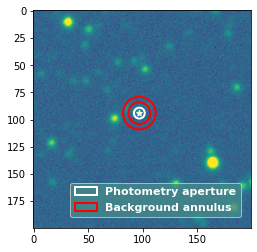

In [93]:
#Code Astro Group 36 Project
#Creating a stellar lightcurve

"""
Input: fits image, stellar coordinates
Output: lightcurve
"""

#Importing all necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from photutils.aperture import SkyCircularAperture
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.time import Time
import astropy.wcs as wcs
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats, aperture_photometry
from astropy.visualization import simple_norm
#from astroquery.astrometry_net import AstrometryNet

#Inputs: 
fitsfile = 'updated_coords.fits'
radec = ['19:05:36.3066', '28:38:04.028']
pixels = [4785, 3188]

# importing the fits file and extracting data
image_file = get_pkg_data_filename(fitsfile)
image_data = fits.getdata(image_file, header=True)
data = image_data[0]
hdr = image_data[1]


#Extracting the time from the image header and converting to MJD
time = hdr['DATE-OBS']
print(time)
t = Time(time, format='isot', scale='utc')
print(t.mjd)

#Converting the input coordinates to pixel coordinates in the image
"""
hdulist = fits.open(fitsfile, memmap=True)
w = wcs.WCS(hdr, hdulist)
print(w)
xy = w.wcs_world2pix(radec, 1) # maybe try skycoord to pixel
print(xy)
"""

#Shrinking the data to a reasonable size
limx = data.shape[0]//2
limy = data.shape[1]//2
print(limx, limy)
small_data = data[limx-100:limx+100, limy-100:limy+100]
small_pixels = [pixels[0]-limy+100, pixels[1]-limx+100]

#Checking that the location in pixels is correct by plotting
norm = simple_norm(data, 'sqrt', percent=99)
plt.figure()
plt.imshow(small_data, norm=norm)
plt.scatter(small_pixels[0], small_pixels[1], color='w', marker='*')

#Using pixel location to find flux of star
#Getting the mean background 
aperture = CircularAperture(small_pixels, r=5) #radius = 5 pixels
annulus_aperture = CircularAnnulus(small_pixels, r_in=10, r_out=15) #annulus from 10 - 15 pixels
aperstats = ApertureStats(small_data, annulus_aperture)
bkg_mean = aperstats.mean

#Getting the aperture area
phot_table = aperture_photometry(small_data, aperture)
aperture_area = aperture.area_overlap(small_data)

#Getting the photometry within the aperture
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table['aperture_sum'] - total_bkg
print(phot_bkgsub) #total counts within the aperture

#Plotting the annulus and aperture as a check
ap_patches = aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})

#Flux = Gain * Counts / Exptime 

